In [1]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

comed_df = pd.read_csv('COMED_hourly.csv', index_col=["Datetime"], parse_dates=["Datetime"])
# Sort Data
comed_df.sort_index(inplace=True)

In [61]:
comed_df

,COMED_MW
Datetime,
2011-01-01 01:00:00,9631.0
2011-01-01 02:00:00,9273.0
2011-01-01 03:00:00,9011.0
2011-01-01 04:00:00,8741.0
2011-01-01 05:00:00,8694.0
...,...
2018-08-02 20:00:00,16437.0
2018-08-02 21:00:00,15590.0
2018-08-02 22:00:00,15086.0


# Preprocessing Data for Model

In [2]:
# Looking for Duplicates 

comed_df[comed_df.index.duplicated(keep=False)]



,COMED_MW
Datetime,
2014-11-02 02:00:00,9184.0
2014-11-02 02:00:00,8869.0
2015-11-01 02:00:00,8270.0
2015-11-01 02:00:00,7923.0
2016-11-06 02:00:00,8028.0
2016-11-06 02:00:00,7814.0
2017-11-05 02:00:00,8198.0
2017-11-05 02:00:00,7878.0


In [3]:
# Make Duplicates into mean 
comed_df = comed_df.groupby('Datetime').agg(np.mean)
comed_df

,COMED_MW
Datetime,
2011-01-01 01:00:00,9631.0
2011-01-01 02:00:00,9273.0
2011-01-01 03:00:00,9011.0
2011-01-01 04:00:00,8741.0
2011-01-01 05:00:00,8694.0
...,...
2018-08-02 20:00:00,16437.0
2018-08-02 21:00:00,15590.0
2018-08-02 22:00:00,15086.0


In [4]:
# Set DatetimeIndex Frequency due to duplicates datatimes
comed_df = comed_df.asfreq('H')

In [5]:
#Check for null values 
comed_df.COMED_MW.isna().sum()

11

In [6]:
# impute values for missing Comed_mw

comed_df['COMED_MW'] = comed_df['COMED_MW'].interpolate(limit_area='inside', limit=None)


In [67]:
# Test for stationarity 

from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(comed_df['COMED_MW'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'number of Lags: {adf_result[2]}')
print(f'Number of Obs: {adf_result[3]}')


ADF Statistic: -14.862202807423168
p-value: 1.712494424950651e-27
number of Lags: 61
Number of Obs: 66442


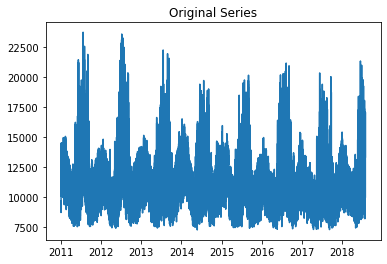

In [68]:
# Difference 
plt.plot(comed_df.COMED_MW)
plt.title ("Original Series")
plt.show()

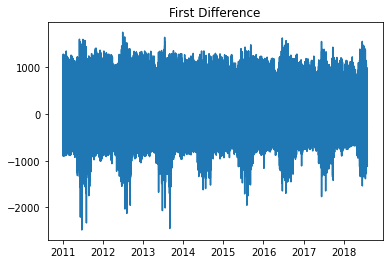

In [69]:
# First Difference 
plt.plot(comed_df.COMED_MW.diff().dropna())
plt.title ("First Difference")
plt.show()

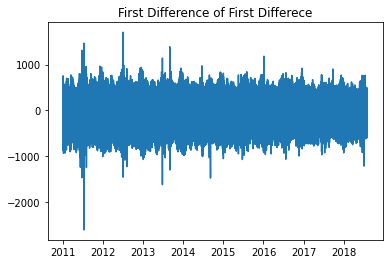

In [70]:
plt.plot(comed_df.COMED_MW.diff().diff().dropna())
plt.title ("First Difference of First Differece")
plt.show()

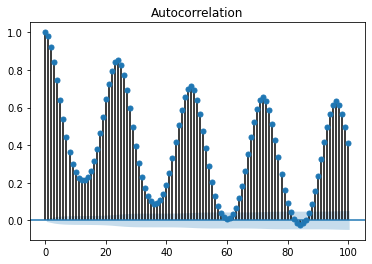

In [71]:
# Autocorrelation for Moving Average 

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(comed_df.COMED_MW,lags=100)
plt.show()

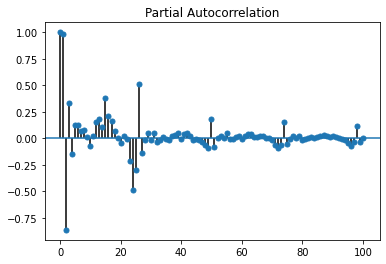

In [72]:
#PACF for AR 
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(comed_df['COMED_MW'], lags=100)
plt.show()

## SAMIRA Model

In [7]:
from datetime import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

#split data into testing and training sets. Traning on 5 years of data 2012 to 2017. Testing on 2017 data
train_set = comed_df.loc[(comed_df.index >= datetime(2012, 1,1)) & (comed_df.index < datetime(2017,1, 1)), 'COMED_MW']
test_set =comed_df.loc[(comed_df.index >= datetime(2017,1,1)),'COMED_MW']


In [102]:
train_set

Datetime
2012-01-01 00:00:00    10335.0
2012-01-01 01:00:00     9906.0
2012-01-01 02:00:00     9407.0
2012-01-01 03:00:00     9086.0
2012-01-01 04:00:00     8758.0
                        ...   
2016-12-31 19:00:00    11587.0
2016-12-31 20:00:00    11549.0
2016-12-31 21:00:00    11273.0
2016-12-31 22:00:00    11085.0
2016-12-31 23:00:00    10801.0
Freq: H, Name: COMED_MW, Length: 43848, dtype: float64

In [8]:
train_data = [MW for MW in train_set]
test_data = [MW for MW in test_set]


model = SARIMAX(train_data, order=(1,0,0), seasonal_order=(1,0,0,24), enforce_stationarity=False, enfore_invertibility=False)
model_fit = model.fit()


In [104]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                43848
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 24)   Log Likelihood             -296366.138
Date:                            Sun, 13 Nov 2022   AIC                         592738.275
Time:                                    03:03:51   BIC                         592764.339
Sample:                                         0   HQIC                        592746.490
                                          - 43848                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9921      0.000   2156.989      0.000       0.991       0.993
ar.S.L24       0.9010      0.002    514.211      0.000       0.898       0.904
sigma2      4.381e+04    146.463    299.151      0.000    4.35e+04    4.41e+04
===================================================================================
Ljung-Box (L1) (Q):               24054.95   Jarque-Bera (JB):             92263.29
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
results=model_fit.predict(len(test_data))
results

array([10948.01034721, 10175.91645599,  9633.11532476, ...,
       11414.29013656, 11048.42882977, 10750.22756933])

In [16]:
len(results)

29951

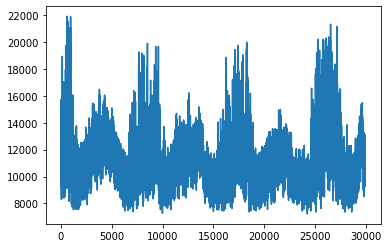

In [18]:
plt.plot(results)
plt.show()

In [ ]:
plt.plot(results_predict)